# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import math
import scipy.optimize as opt
import scipy
import functools
from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams['figure.dpi'] = 400
plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [2]:
# !pip install tueplots==0.0.2
# !pip install scikit-learn
# !pip install dash plotly


In [3]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)
    
    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(kind_file_paths, 'rb') as handle:
        kind_files = pickle.load(handle)

for kind in KINDS:
    print(f"Files containing {kind} data:\n\t{kind_files[kind]}")

Files containing wind data:
	['data/wind/produkt_zehn_min_ff_19961220_19991231_02115.txt', 'data/wind/produkt_zehn_min_ff_20000101_20091231_02115.txt', 'data/wind/produkt_zehn_min_ff_20100101_20191231_02115.txt', 'data/wind/produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['data/air_temperature/produkt_zehn_min_tu_19961219_19991231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20000101_20091231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20100101_20191231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20200101_20221231_02115.txt']
Files containing precipitation data:
	['data/precipitation/produkt_zehn_min_rr_19961219_19991231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20000101_20091231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20100101_20191231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20200101_20221231_02115.txt']
Files containing solar data:
	['data/solar/produkt_zehn_min_sd_19961219_199912

In [4]:
kind_df = { kind: None for kind in KINDS }
for kind, files in kind_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    # print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

In [5]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

# Display the result
df

,STATIONS_ID,MESS_DATUM,QN_wind,FF_10_wind,DD_10_wind,eor_wind,QN_air_temperature,PP_10_air_temperature,TT_10_air_temperature,TM5_10_air_temperature,...,RWS_IND_10_precipitation,QN_precipitation,eor_precipitation,QN_solar,DS_10_solar,GS_10_solar,SD_10_solar,LS_10_solar,QN_solar,eor_solar
0,2115,1996-12-19 10:40:00,1,15.8,70,eor,1.0,1008.2,2.0,1.9,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
1,2115,1996-12-19 10:50:00,1,16.2,70,eor,1.0,1008.1,2.0,1.9,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
2,2115,1996-12-19 11:00:00,1,16.6,70,eor,1.0,1008.1,2.1,2.1,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
3,2115,1996-12-19 11:10:00,1,16.0,80,eor,1.0,1008.1,2.3,2.2,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
4,2115,1996-12-19 11:20:00,1,16.3,70,eor,1.0,1008.0,2.1,2.0,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348936,2115,2022-12-31 23:10:00,3,13.6,230,eor,NaN,1000.6,11.1,10.3,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348937,2115,2022-12-31 23:20:00,3,12.4,230,eor,NaN,1000.6,10.9,10.2,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348938,2115,2022-12-31 23:30:00,3,12.6,230,eor,NaN,1000.5,11.1,10.3,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348939,2115,2022-12-31 23:40:00,3,12.6,230,eor,NaN,1000.6,11.2,10.4,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor


## Explorative Data Analysis

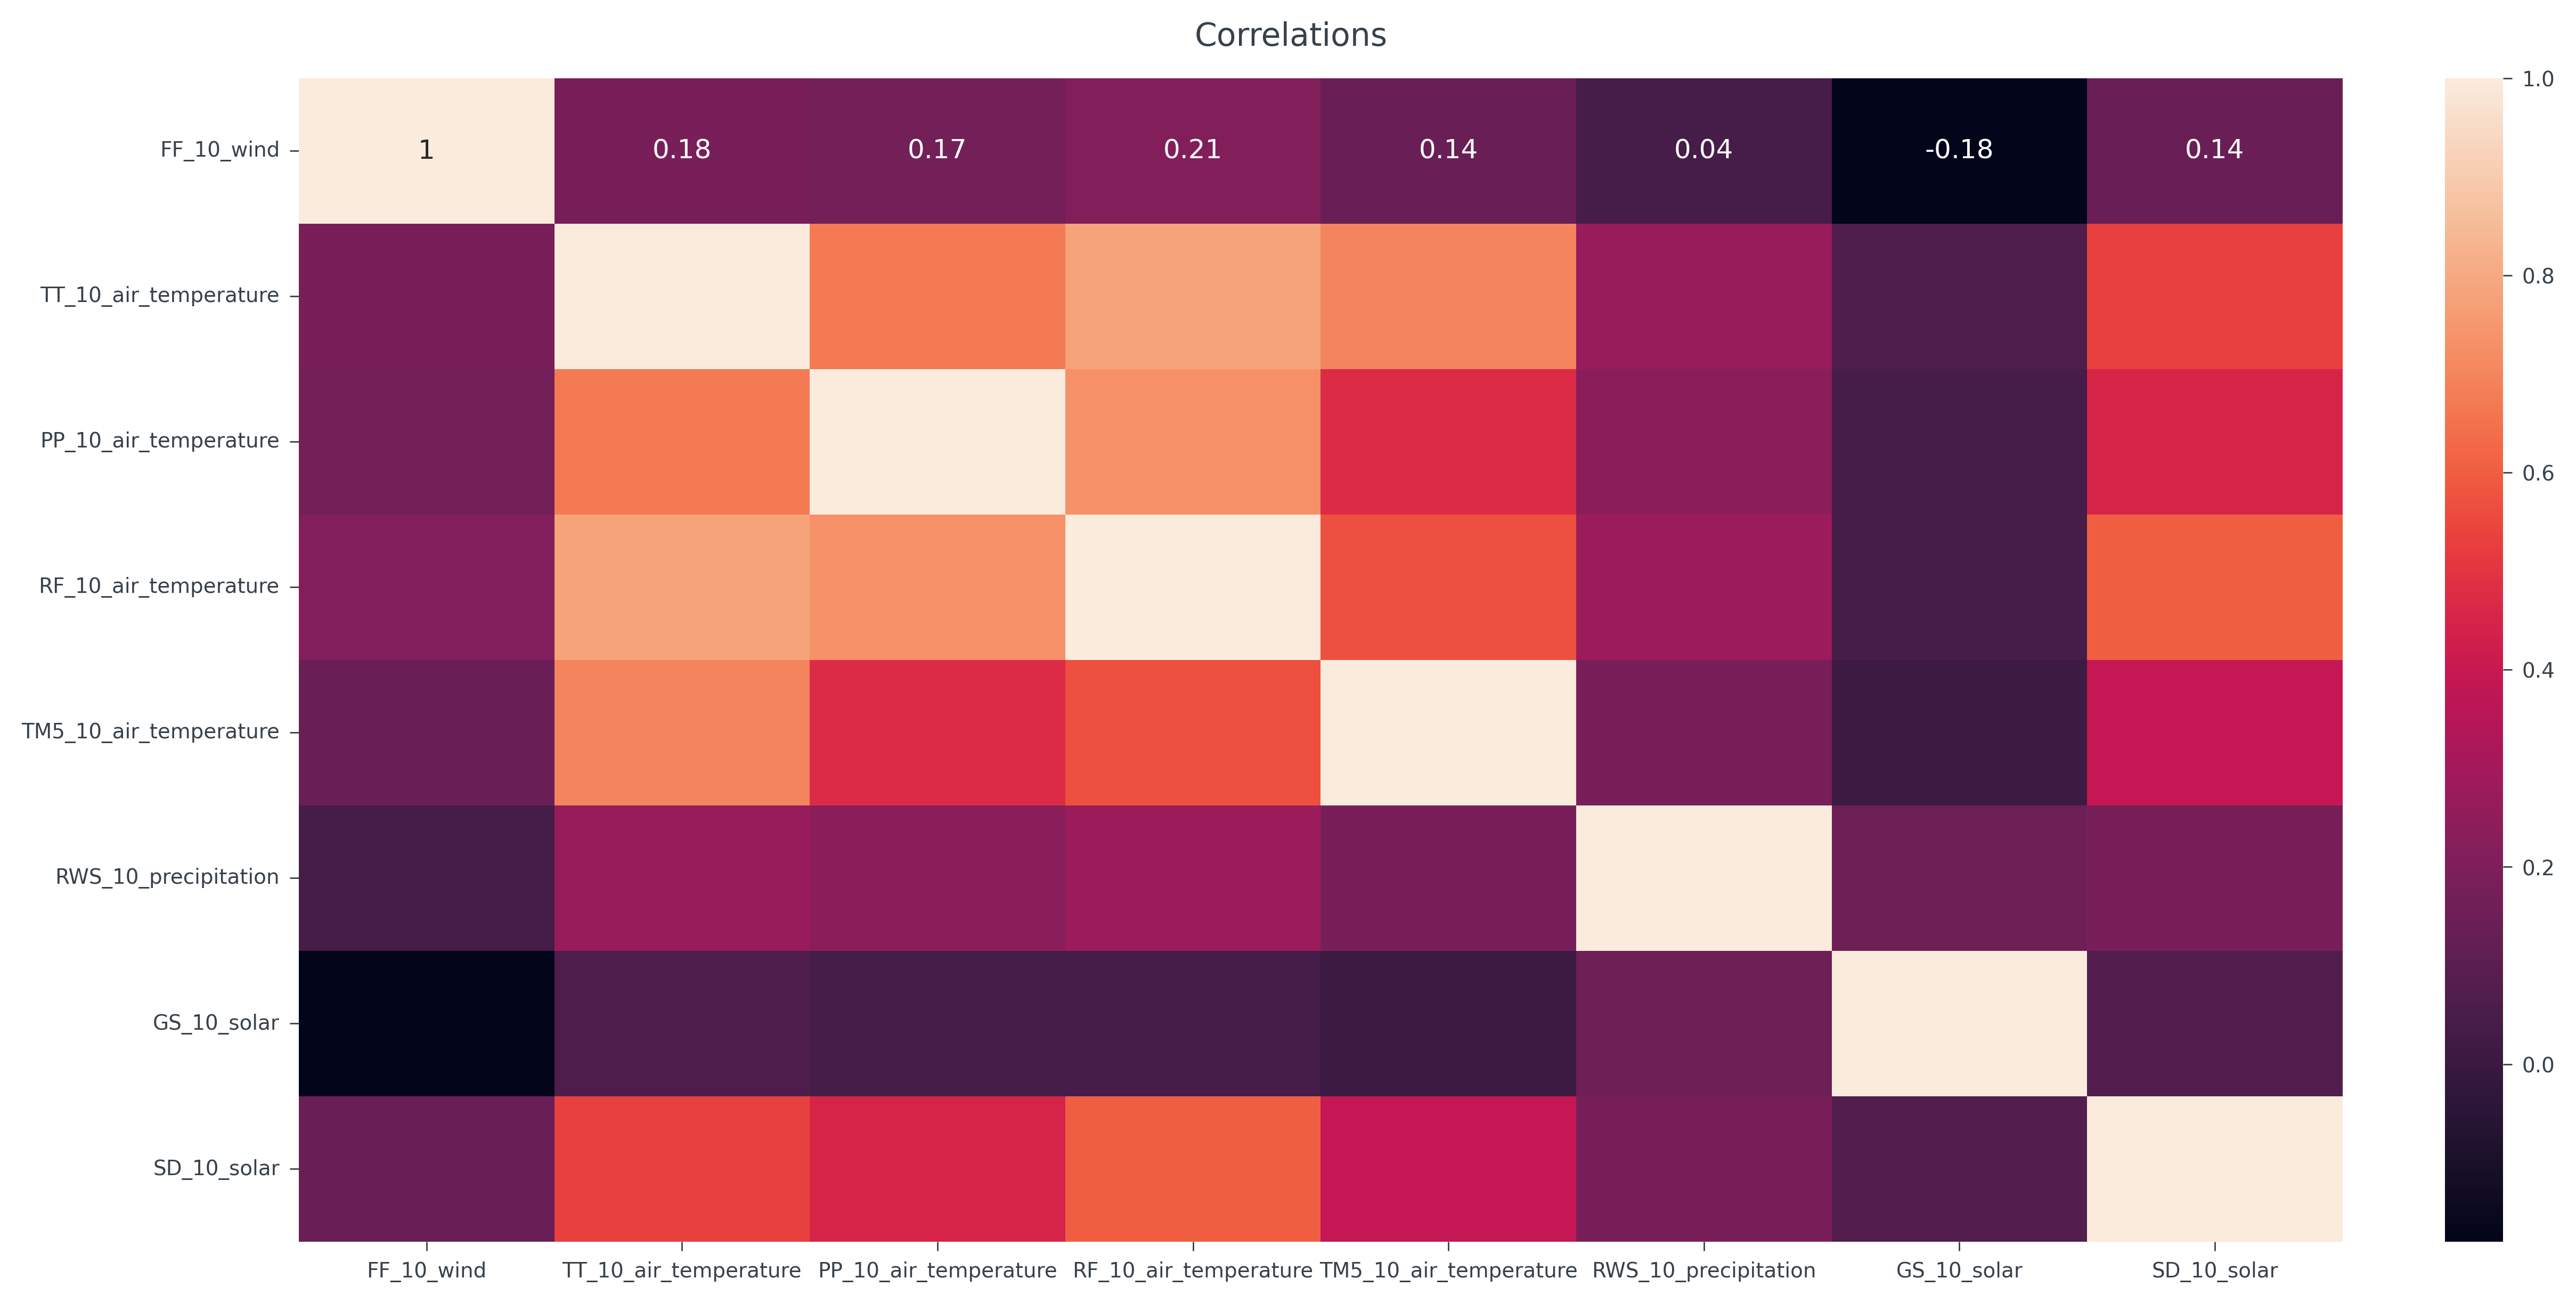

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

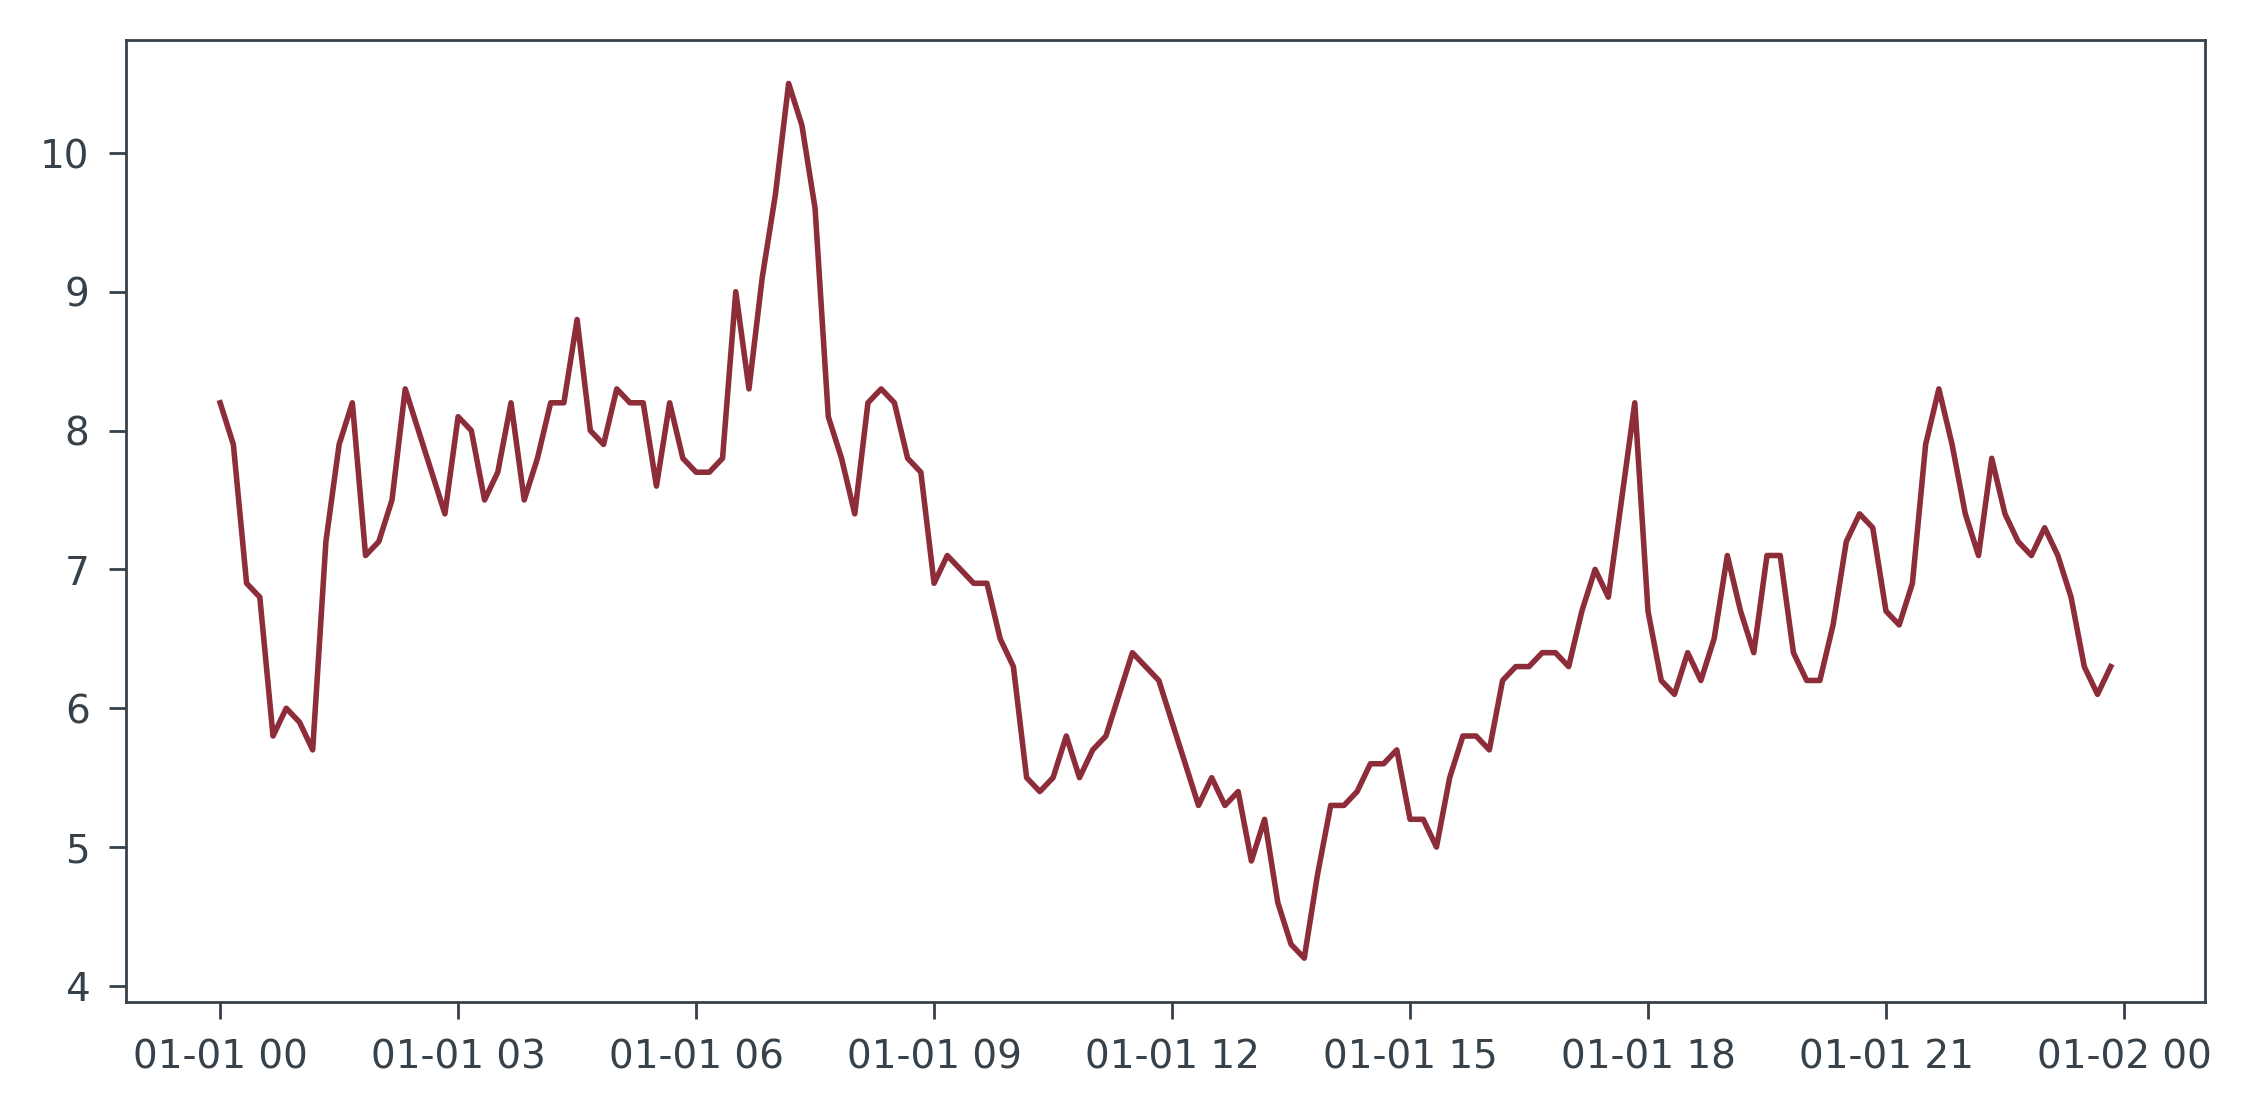

In [7]:
wind_df = kind_df["wind"]
wind_df['FF_10_wind'] = wind_df['FF_10_wind'].replace(-999, float('nan'))
mask = (wind_df['MESS_DATUM'].dt.day == 1) & (wind_df['MESS_DATUM'].dt.month == 1) & (wind_df['MESS_DATUM'].dt.year == 2022)
plt.plot(wind_df[mask]["MESS_DATUM"], wind_df[mask]["FF_10_wind"])


### Min and Max Wind Speed (Orignal Dataset)

In [32]:
wind = kind_df["wind"]
wind

,STATIONS_ID,MESS_DATUM,QN_wind,FF_10_wind,DD_10_wind,eor_wind,year,day,month,YEAR,MONTH,DAY
0,2115,1996-12-19 10:40:00,1,15.8,70,eor,1996,19,12,1996,12,19
1,2115,1996-12-19 10:50:00,1,16.2,70,eor,1996,19,12,1996,12,19
2,2115,1996-12-19 11:00:00,1,16.6,70,eor,1996,19,12,1996,12,19
3,2115,1996-12-19 11:10:00,1,16.0,80,eor,1996,19,12,1996,12,19
4,2115,1996-12-19 11:20:00,1,16.3,70,eor,1996,19,12,1996,12,19
...,...,...,...,...,...,...,...,...,...,...,...,...
154742,2115,2022-12-31 23:10:00,3,13.6,230,eor,2022,31,12,2022,12,31
154743,2115,2022-12-31 23:20:00,3,12.4,230,eor,2022,31,12,2022,12,31
154744,2115,2022-12-31 23:30:00,3,12.6,230,eor,2022,31,12,2022,12,31
154745,2115,2022-12-31 23:40:00,3,12.6,230,eor,2022,31,12,2022,12,31


In [91]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def get_min_max_fig(wind, plot_title):
      df = (wind.groupby(['year', 'month', 'day'])['FF_10_wind']
            .agg([('Count','size'), ('Min','min'), ('Max','max'), ('Mean','mean')])
            .reset_index())

      df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])

      fig = go.Figure()
      fig.add_trace(go.Scatter(x=df['Date'], y=df['Max'], mode='lines', marker=dict(color='red', size=3), name='Max'))
      fig.add_trace(go.Scatter(x=df['Date'], y=df['Min'], mode='lines', marker=dict(color='lightskyblue', size=3), name='Min'))
      fig.update_layout(xaxis_title="Date", yaxis_title="Daily Wind Speed", title=plot_title)
      
      return fig

fig = get_min_max_fig(kind_df["wind"], 'Min and Max Daily Wind Speed Over Time')
fig.show()


/Users/zingo/opt/anaconda3/envs/datalit/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [93]:
# Standard Deviation Method

from numpy import mean, std

wind = kind_df["wind"]
wind_speed_data = wind['FF_10_wind']
n_std = 7

wind_speed_mean, wind_speed_std = mean(wind_speed_data), std(wind_speed_data)
cut_off = wind_speed_std * n_std
lower_threshold, upper_threshold = wind_speed_mean - cut_off, wind_speed_mean + cut_off

# Identify outliers based on the std threshold
outliers_mask    = (wind_speed_data > upper_threshold)
df_no_outliers   = wind[~outliers_mask]
df_outliers_only = wind[outliers_mask]

fig = get_min_max_fig(df_no_outliers, 'Min and Max Daily Wind Speed Over Time After Filtering using Standard Deviation (n_std=7) ')
fig.show()


/Users/zingo/opt/anaconda3/envs/datalit/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [102]:
# Interquartile Range

# Source https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

from numpy import percentile

wind = kind_df["wind"]
wind_speed_data = wind['FF_10_wind']
n_std = 7

q25, q75 = percentile(wind_speed_data, 25), percentile(wind_speed_data, 75)
iqr = q75 - q25

cut_off = iqr * 1.5
lower_threshold, upper_threshold = q25 - cut_off, q75 + cut_off

# Identify outliers based on the std threshold
outliers_mask    = (wind_speed_data > upper_threshold)
df_no_outliers   = wind[~outliers_mask]
df_outliers_only = wind[outliers_mask]

fig = get_min_max_fig(df_no_outliers, 'Min and Max Daily Wind Speed Over Time After Filtering using Interquartile Range ')
fig.show()

/Users/zingo/opt/anaconda3/envs/datalit/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [101]:
# Z-score Method
from scipy.stats import zscore

wind = kind_df["wind"]
wind_speed_data = wind['FF_10_wind']
n_std = 7

# Calculate Z-scores
z_scores = zscore(wind_speed_data)

outliers_mask = (abs(z_scores) > n_std)

df_no_outliers   = wind[~outliers_mask]
df_outliers_only = wind[outliers_mask]

fig = get_min_max_fig(df_no_outliers, 'Min and Max Daily Wind Speed Over Time After Filtering using Z-score n (n_std=7) ')
fig.show()


/Users/zingo/opt/anaconda3/envs/datalit/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

